In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings("ignore")
import os
import random
%load_ext autoreload
%autoreload 2
from final_deliverable.utils_final import *
from final_deliverable.ridge_mvo import *

In [2]:
rets_data_path = os.path.dirname(os.getcwd()) + '/data'
pred_data_path = os.path.dirname(os.getcwd()) + '/backtest'
analysis_data_path = os.path.dirname(os.getcwd()) + '/analysis'
weekly_rets_file = rets_data_path + '/broad_assets_weekly_rets.xlsx'
global_rets_file = rets_data_path + '/equity_global_monthly_rets.xlsx'
domestic_rets_file = rets_data_path + '/equity_domestic_monthly_rets.xlsx'
broad_assets_pred_file = analysis_data_path + '/broad_asset XGBoost-PCA Asset Mean Threshold Predictions.xlsx'
global_pred_file = pred_data_path + '/equity_global_predictions.xlsx'
domestic_pred_file = analysis_data_path + '/equity_domestic XGBoost-LDA Basic Threshold Predictions.xlsx'

## <center> Before Everything

This notebook is for the implementation of the weighting algorithm incorporating the ridge MVO technique and the ranking results given by the classifiers. Below are the data we want for the ridge MVO:

1. For Broad Assets Universe, we need the **weekly returns** `broad_assets_weekly_rets.xlsx` from dir `/data` and the classification prediction results `broad_assets_predictions.xlsx` from dir `/backtest`.
2. Similarly for Equity Domestic/Global, we need both the **monthly returns** data `equity_domestic_monthly_rets.xlsx` and `equity_global_monthly_rets.xlsx` from dir `/data` and also the classification prediction results `equity_domestic_predictions.xlsx` and `equity_global_prediction.xlsx` from dir `/backtest`.

One housekeeping that we need to do is to match the earliest starting dates in the returns data with those in the predictions data.

<span style="color:red">For the convenience of leveraging the existing dynamic weighting function implementation, all of the original data import **DOES NOT** carry the index column.</span>
***

## Weekly / Monthly Returns Data Import

In [3]:
data = pd.read_excel(weekly_rets_file)
global_data = pd.read_excel(global_rets_file)
domestic_data = pd.read_excel(domestic_rets_file)
display(data.head(), global_data.head(), domestic_data.head())

,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
0,2000-07-31,0.0152,0.0757,-0.0023,0.0009,0.0422,0.0050,0.0373,0.0021,-0.0025,-0.0084,-0.0318
1,2000-08-07,0.0679,0.0526,0.0159,0.0134,0.0365,-0.0237,-0.0196,-0.0116,0.0241,-0.0266,0.0346
2,2000-08-14,0.0157,0.0023,0.0152,0.0063,0.0171,0.0254,0.0294,0.0369,0.0085,0.0063,0.0481
3,2000-08-21,0.0095,0.0566,-0.0018,-0.0003,0.0068,-0.0264,0.0016,-0.0024,0.0077,0.0018,0.0384
4,2000-08-28,0.0184,0.0653,0.0019,0.0041,0.0379,-0.0353,0.0195,-0.0170,0.0019,-0.0095,0.0313


,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 43,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52
0,2003-04-14,0.0059,0.0035,0.0000,0.0069,0.0000,0.0000,0.0090,0.0042,0.0000,...,0.0000,0.0000,0.0000,-0.0028,-0.0009,-0.0028,0.0000,0.0000,0.0207,0.0204
1,2003-05-01,0.1023,0.1299,0.0000,0.0811,0.0000,0.0000,0.0997,0.0606,0.0000,...,0.0000,0.0000,0.0000,0.0328,0.0056,0.0169,0.0000,0.0000,0.0332,0.0638
2,2003-06-02,0.0422,0.3734,0.0000,0.1223,0.0000,0.0000,0.1478,0.2189,0.0000,...,0.0000,0.0000,0.0000,0.0603,0.0047,0.0370,0.0000,0.0000,0.0593,0.0683
3,2003-07-01,0.1001,0.1734,0.0000,0.0544,0.0000,0.0000,0.0618,0.1381,0.0000,...,0.0000,0.0000,0.0000,-0.0115,0.0035,-0.0025,0.0000,0.0000,0.0158,0.0260
4,2003-08-01,0.0754,0.1196,0.0000,-0.0382,0.0000,0.0000,0.0560,0.0665,0.0000,...,0.0000,0.0000,0.0000,-0.0922,-0.0049,-0.0515,0.0000,0.0000,-0.0002,0.0366


,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
0,2001-01-03,0.0000,0.0000,0.0000,-0.0338,0.0000,0.0000,0.0000,-0.0137,0.0000,...,0.0115,0.0419,0.0675,0.1113,0.0419,0.0177,-0.0411,-0.0118,-0.0171,-0.0013
1,2001-02-01,0.0000,0.0000,0.0000,-0.0378,0.0000,0.0000,0.0000,0.0048,0.0000,...,0.0166,0.0215,-0.0046,0.0319,0.0253,-0.0520,-0.0496,0.0120,0.0114,0.0100
2,2001-03-01,0.0000,0.0000,0.0000,0.0269,0.0000,0.0000,0.0000,0.0441,0.0000,...,-0.0172,0.0704,0.0395,-0.1746,0.0087,0.0011,0.0999,0.0110,0.0135,0.0058
3,2001-04-02,0.0000,0.0000,0.0000,-0.0210,0.0000,0.0000,0.0000,0.0367,0.0000,...,-0.0038,-0.0238,-0.0028,-0.1542,-0.0019,-0.0201,0.0181,0.0008,-0.0176,0.0081
4,2001-05-01,0.0000,0.0000,0.0000,0.0414,0.0000,0.0000,0.0000,0.0314,0.0000,...,0.0053,0.1430,0.0607,0.2815,0.0649,0.0244,0.0337,-0.0122,-0.0239,0.0032


## Broad Assets / Equity Global & Domestic Classification Prediction Results Import

In [4]:
broad_assets_pred = pd.read_excel(broad_assets_pred_file)
global_pred = pd.read_excel(global_pred_file)
domestic_pred = pd.read_excel(domestic_pred_file)
domestic_pred = domestic_pred.fillna(0)
display(broad_assets_pred.head(), global_pred.head(), domestic_pred.head())

,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
0,2004-10-11,1,1,1,0,1,0,1,0,0,0,0
1,2004-10-18,0,1,0,1,1,1,1,1,0,0,1
2,2004-10-25,1,0,0,0,0,0,0,0,1,1,1
3,2004-11-01,1,0,1,1,0,0,0,0,1,0,0
4,2004-11-08,0,0,0,0,0,1,1,0,1,0,0


,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 43,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52
0,2007-05-01,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,0
1,2007-06-01,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,1
2,2007-07-02,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,1
3,2007-08-01,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,0
4,2007-09-04,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,1,1


,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
0,2004-06-01,0.0000,0.0000,0.0000,0,0,0,0,1,0,...,0,0,0,0,1,1,0,1,1,1
1,2004-07-01,0.0000,0.0000,0.0000,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1
2,2004-08-02,0.0000,0.0000,0.0000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,1
3,2004-09-01,0.0000,0.0000,0.0000,0,0,0,0,1,0,...,1,0,0,0,1,1,0,1,1,0
4,2004-10-01,0.0000,0.0000,0.0000,1,0,0,0,1,0,...,1,1,1,1,1,1,1,0,0,0


In [5]:
broad_assets_start_date_predictions = broad_assets_pred['Date'].min()
global_start_date_predictions = global_pred['Date'].min()
domestic_start_date_predictions = domestic_pred['Date'].min()

data = data[data['Date'] >= broad_assets_start_date_predictions].reset_index(drop = True)
global_data = global_data[global_data['Date'] >= global_start_date_predictions].reset_index(drop = True)
domestic_data = domestic_data[domestic_data['Date'] >= domestic_start_date_predictions].reset_index(drop = True)

display(data.head(), global_data.head(), domestic_data.head())

,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
0,2004-10-11,-0.0187,-0.0299,0.0086,0.0059,-0.0392,-0.0109,0.0116,-0.0139,-0.0220,0.0383,0.1149
1,2004-10-18,-0.0187,0.0266,0.0171,0.0121,-0.0196,0.0511,-0.0138,-0.0394,-0.0088,-0.0280,-0.0213
2,2004-10-25,-0.0345,-0.0350,0.0226,0.0120,-0.0021,-0.0328,0.0110,-0.0034,-0.0467,0.0588,0.0639
3,2004-11-01,0.0665,0.0789,-0.0210,-0.0130,0.0540,0.0671,0.0500,0.0546,0.0065,-0.0048,-0.0840
4,2004-11-08,0.0616,0.0518,-0.0201,-0.0148,0.0517,-0.0118,0.0599,0.0485,-0.0269,0.0197,-0.0139


,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 43,Asset 44,Asset 45,Asset 46,Asset 47,Asset 48,Asset 49,Asset 50,Asset 51,Asset 52
0,2007-05-01,0.0289,0.0282,0.0555,0.0532,0.0317,0.0548,0.0432,0.0129,0.0746,...,0.0370,0.0847,0.0293,0.0081,0.0024,0.0050,0.0000,0.0000,0.0458,0.0578
1,2007-06-01,0.0359,0.0399,0.0343,0.0499,0.1469,0.0507,0.0850,0.0298,0.0576,...,0.0599,0.0041,0.1122,-0.0290,-0.0008,-0.0182,0.0000,0.0000,0.0364,0.0288
2,2007-07-02,0.0292,0.0423,0.0787,0.0057,0.0136,0.0307,-0.0049,0.0095,0.0393,...,-0.0066,0.0411,0.0186,0.0003,0.0059,0.0011,0.0000,0.0000,-0.0106,0.0128
3,2007-08-01,-0.0377,-0.0019,-0.1094,-0.0530,-0.0152,-0.0271,-0.0733,-0.0387,-0.0241,...,-0.0198,-0.0599,-0.0554,0.0255,0.0074,0.0182,0.0000,0.0000,-0.0353,-0.0023
4,2007-09-04,-0.0294,0.1453,-0.0669,0.0333,0.0255,0.0353,0.0224,0.0557,0.0404,...,0.0079,-0.0306,0.0905,0.0201,0.0118,0.0236,0.0000,0.0000,0.0181,0.0372


,Date,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
0,2004-06-01,0.0000,0.0000,0.0000,-0.0230,0.0000,0.0000,0.0000,-0.0136,0.0000,...,-0.0405,0.0036,0.0117,0.0395,0.0363,0.0635,-0.0040,-0.0099,-0.0129,-0.0019
1,2004-07-01,0.0000,0.0000,0.0000,0.0199,0.0000,0.0000,0.0000,0.0255,0.0000,...,-0.0031,0.1490,0.0575,0.0250,0.0207,0.0467,0.0077,0.0136,0.0218,0.0014
2,2004-08-02,0.0000,0.0000,0.0000,0.0235,0.0000,0.0000,0.0000,0.0270,0.0000,...,-0.0108,-0.0294,-0.0409,-0.1089,0.0022,0.0246,0.0199,0.0119,0.0148,0.0033
3,2004-09-01,0.0000,0.0000,0.0000,-0.0362,0.0000,0.0000,0.0000,0.0279,0.0000,...,0.0376,-0.0094,0.0098,-0.0148,0.0134,0.0229,0.0307,0.0264,0.0414,0.0069
4,2004-10-01,0.0000,0.0000,0.0000,0.0400,0.0000,0.0000,0.0000,0.0384,0.0000,...,0.0035,-0.0022,0.0517,0.0649,0.0352,0.0273,-0.0152,-0.0006,0.0034,-0.0019


***
## Ridge MVO Weighting Algorithm Based on the Classification Result

The process begins with the following inputs: the asset returns, the classification dataset with predicted returns, a risk tolerance parameter ($\sigma$), which is fixed of $0.02$ for the expected annual volatility, a ridge penalty, which is also fixed of $0.03$, a list of lookback periods, 4, 13, 26, 39, and 52 weeks, and an evaluation metric (Sharpe ratio or Drawdown) since we considered these two as the objective function to either maximize or minimize. Optional lists may also store the start and end dates for yearly intervals.

The dataset is split into yearly intervals, with start and end dates identified using a 365-day rolling window. These intervals are indexed for subsequent optimization.

### Highlight1: How the lookback periods being chosen dynamically?

We exhaustively looped through each lookback period in `self.lookback_period`. For each period, it calls `self.single_dynamic_ridge_optimization(start_ind, look_back)` to compute the performance metric (Sharpe ratio or Drawdown) for that specific lookback period based on the metrics we select. Then we stored the results of each lookback period in a list (or NumPy array). 
- For 'Sharpe', it stores the Sharpe ratio for each period. 
- For 'Drawdown', it stores the Drawdown for each period.

After evaluating all candidate lookback periods:
- If 'Sharpe' is selected, the code identifies the period with the highest Sharpe ratio using np.argmax.
- If 'Drawdown' is selected, the code identifies the period with the lowest Drawdown using np.argmin.

An example is given in the following:
Suppose self.lookback_period = [4, 13, 26, 39, 52] and the evaluation metric is 'Sharpe'. Here's how the process unfolds:

- For lookback period 4, the function calculates the Sharpe ratio (e.g., 0.45).
- For lookback period 13, the Sharpe ratio is calculated (e.g., 0.50).
- For lookback period 26, the Sharpe ratio is calculated (e.g., 0.55).
- For lookback period 39, the Sharpe ratio is calculated (e.g., 0.53).
- For lookback period 52, the Sharpe ratio is calculated (e.g., 0.51).

The Sharpe ratios [0.45, 0.50, 0.55, 0.53, 0.51] are stored. Using np.argmax, the code identifies 26 (the lookback period with the highest Sharpe ratio, 0.55) as the optimal period.
If 'Drawdown' were the evaluation metric, the same process would identify the lookback period with the lowest Drawdown.

### Highlight2: How does the optimization works?

First, for periods shorter than the lookback period (look_back), assets with positive classification scores ($\text{row}[j] > 0$) are equally weighted. This ensures initial periods have non-zero weights. For each time step from the end of the lookback period (look_back-1) to the current index (start_ind), the function performed the followings:

1. Selects assets with positive predicted returns ($\text{row}[\text{row} > 0]$).
2. Creates a target matrix of historical returns for the selected assets over the lookback period.
3. Computes the covariance matrix and mean returns of the selected assets.
4. Skips periods with no valid assets.

Then, the objective function is constructed as follows:

$$\text{Objective} = \text{Portfolio Return} - \text{Ridge Penalty} * \text{Sum of Squared Weights}$$
with the constraints:
- Weights sum to 1.
- Weights are non-negative.
- Portfolio variance remains below a user-defined threshold ($\sigma$).

The goal is to maximize returns while penalizing concentrated weights (to encourage diversification). The `scipy.optimize.minimize` function solves this optimization problem using the `SLSQP` method. If optimization fails, weights default to zero for that period. Futhermore, the reason why there's a negative sign is that we want to maximize the returns, but we usually minimize the objective function in default. Thus, changing the sign will automatically switch an maximiazation problem to a minimization problem.

Then, the optimized weights are stored in the weight matrix for each asset.

### Highlight3: How to optimize weights by leveraging the dynamic lookback periods?
We called `find_optimum_lookback` to select the best lookback period based on the evaluation metric. Then for each time step within the start and end indices of the current year (start_ind to end_ind), we followed exactly the same logic as the `single_dynamic_ridge_optimization` works. The only difference is the function `optimize_weight_in_next_year` applies the optimal lookback period to dynamically optimize weights for the **next year**'s portfolio. Then we will need to loop through each yearly interval and call `optimize_weight_in_next_year` to compute optimized weights for the year.
***

## Broad Assets Experiment and Final Decision

Observing two weighting algorithms evaluated by the Sharpe Ratio and Drawdown, we can conclude that for Broad Assets, using Drawdown as the evaluation metric would achieve a better Sharpe and less Max Drawdown.

In [8]:
ind_dict = {f'Asset {i}':i-1 for i in range(1, data.shape[1])}
lookback_periods = [4, 13, 26, 39, 52]

,,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown
cls_ridge,0,0.1634,0.2947,0.5543,-0.1637,0.2271,0.0070,3.4041,-0.0619,-0.0960,-0.5804
cls_equal,0,0.1646,0.2760,0.5962,-0.3186,0.2423,-0.4982,11.0109,-0.0538,-0.0895,-0.6655
benchmark,0,0.1364,0.2457,0.5549,-0.2167,0.2156,-0.1166,7.4761,-0.0488,-0.0793,-0.6375


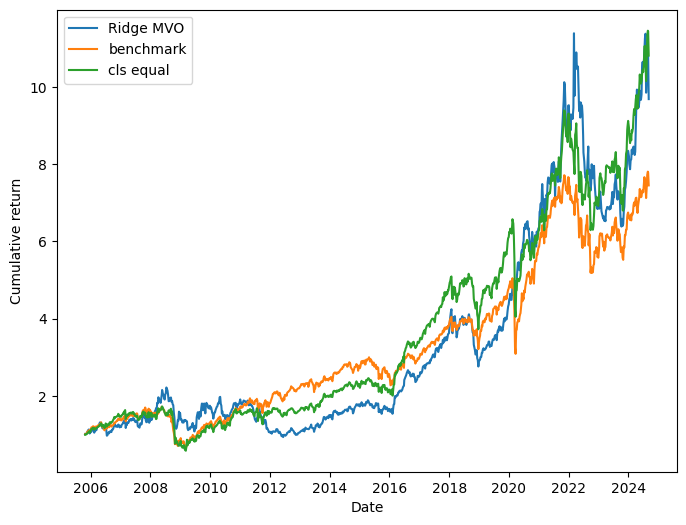

In [9]:
broad_assets_obj_sharpe = dynamic_ridge_optimizer(data, broad_assets_pred, 0.02, 0.01, lookback_periods, annual_factor=52, eval='Sharpe', ind_dict=ind_dict)
broad_assets_obj_sharpe.report_summary_statistics(classification_type='classification_broad_assets')

,,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown
cls_ridge,0,0.1902,0.2912,0.6529,-0.1996,0.2386,0.0087,4.5031,-0.0571,-0.0933,-0.4772
cls_equal,0,0.1646,0.2760,0.5962,-0.3186,0.2423,-0.4982,11.0109,-0.0538,-0.0895,-0.6655
benchmark,0,0.1364,0.2457,0.5549,-0.2167,0.2156,-0.1166,7.4761,-0.0488,-0.0793,-0.6375


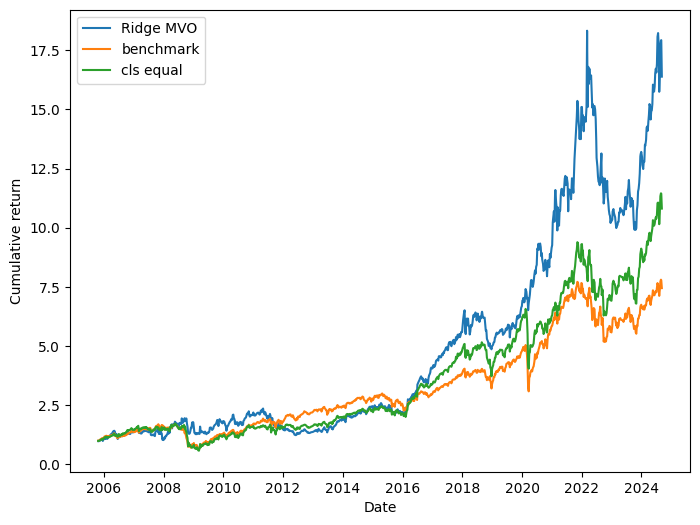

In [10]:
broad_assets_obj_drawdown = dynamic_ridge_optimizer(data, broad_assets_pred, 0.02, 0.01, lookback_periods, annual_factor=52, eval='Drawdown', ind_dict=ind_dict)
broad_assets_obj_drawdown.report_summary_statistics(classification_type='classification_broad_assets')

***
## Equity Global Experiment and Final Decision

For Equity Global, using Drawdown as the evaluation metric would achieve a better Sharpe and less Max Drawdown.

,,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown
cls_ridge,0,0.1267,0.2890,0.4383,-0.2169,0.3487,0.6892,2.0118,-0.1207,-0.1520,-0.5219
cls_equal,0,0.0961,0.1909,0.5035,-0.2292,0.1468,-0.6758,2.1899,-0.0827,-0.1328,-0.3730
benchmark,0,0.0816,0.2003,0.4070,-0.2336,0.1610,-0.5991,2.1169,-0.0901,-0.1410,-0.5016


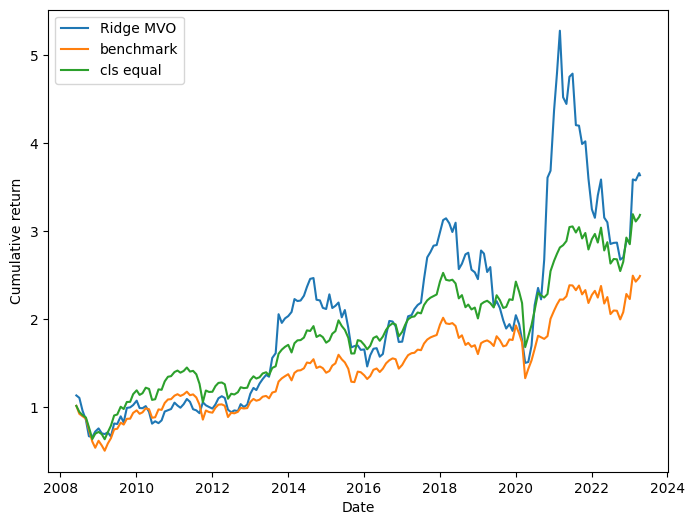

In [11]:
ind_dict = {f'Asset {i}':i-1 for i in range(1, global_data.shape[1])}
lookback_periods = [3, 6, 9, 12]
global_obj_sharpe = dynamic_ridge_optimizer(global_data, global_pred, 0.02, 0.01, lookback_periods, annual_factor = 12, eval='Sharpe', ind_dict=ind_dict)
global_obj_sharpe.report_summary_statistics(classification_type='classification_equity_global')

,,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown
cls_ridge,0,0.1565,0.2625,0.5961,-0.1569,0.2769,0.6157,1.1052,-0.1024,-0.1287,-0.4539
cls_equal,0,0.0961,0.1909,0.5035,-0.2292,0.1468,-0.6758,2.1899,-0.0827,-0.1328,-0.3730
benchmark,0,0.0816,0.2003,0.4070,-0.2336,0.1610,-0.5991,2.1169,-0.0901,-0.1410,-0.5016


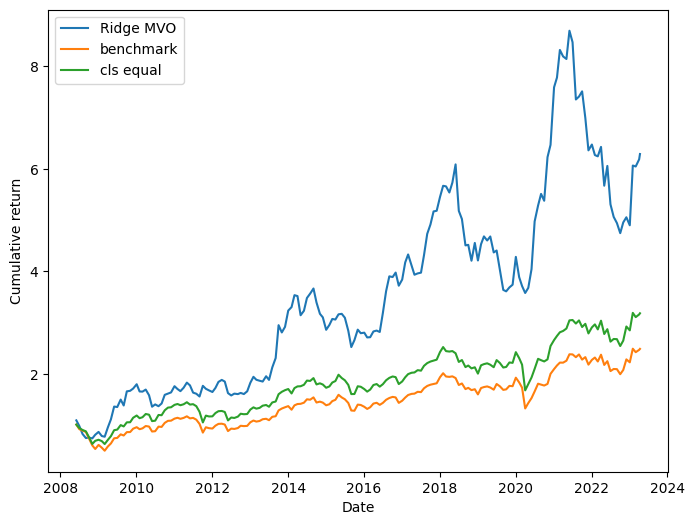

In [12]:
global_obj_drawdown = dynamic_ridge_optimizer(global_data, global_pred, 0.02, 0.01, lookback_periods, annual_factor = 12, eval='Drawdown', ind_dict=ind_dict)
global_obj_drawdown.report_summary_statistics(classification_type='classification_equity_global')

***
## Equity Domestic Experiment and Final Decision

For Equity Domestic, the backtest result of the scenario when the evaluation metric is Sharpe outperform the Drawdown one by tunning the ridge penalty to 0.8. But it does not outperform too much from either the benchmark (equal-weighted original 46 assets) or the cls equal portfolio (equal-weighted assets after the classification selections). If we really want to choose, then the 'Sharpe' one would be the best choice.

,,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown
cls_ridge,0,0.1207,0.1704,0.7082,-0.1836,0.1711,-0.6760,1.9471,-0.0714,-0.1154,-0.4227
cls_equal,0,0.1221,0.1791,0.6818,-0.2503,0.2034,-0.7201,4.0054,-0.0731,-0.1217,-0.4209
benchmark,0,0.1214,0.1904,0.6375,-0.2503,0.1934,-0.5644,3.1992,-0.0689,-0.1288,-0.4870


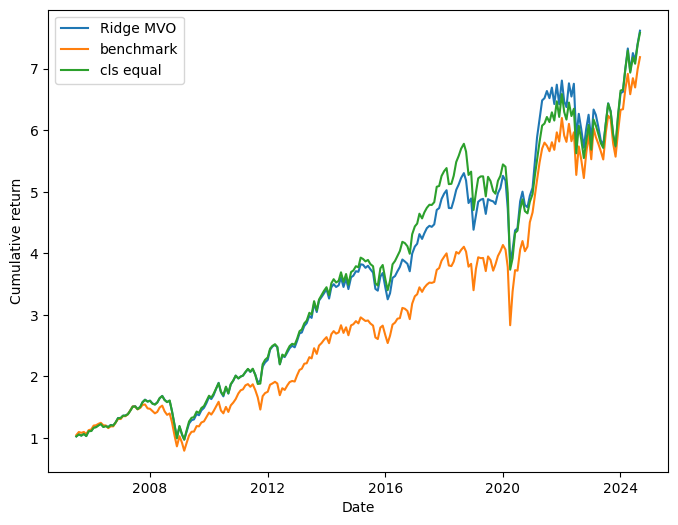

In [6]:
ind_dict = {f'Asset {i}':i-1 for i in range(1, domestic_data.shape[1])}
lookback_periods = [3, 6, 9, 12]
global_obj_sharpe = dynamic_ridge_optimizer(domestic_data, domestic_pred, 0.02, 0.8, lookback_periods, annual_factor = 12, eval='Sharpe', ind_dict=ind_dict)
global_obj_sharpe.report_summary_statistics(classification_type='classification_equity_domestic')

,,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown
cls_ridge,0,0.1168,0.1709,0.6838,-0.2526,0.1396,-1.0808,3.6213,-0.0703,-0.1164,-0.4203
cls_equal,0,0.1221,0.1791,0.6818,-0.2503,0.2034,-0.7201,4.0054,-0.0731,-0.1217,-0.4209
benchmark,0,0.1214,0.1904,0.6375,-0.2503,0.1934,-0.5644,3.1992,-0.0689,-0.1288,-0.4870


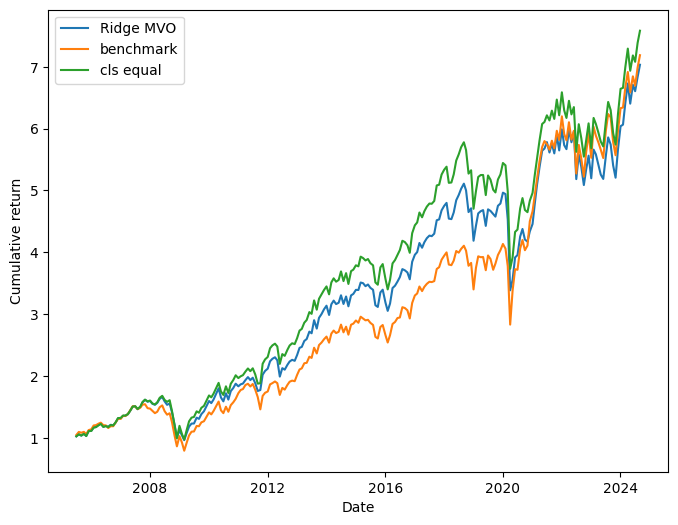

In [7]:
global_obj_sharpe = dynamic_ridge_optimizer(domestic_data, domestic_pred, 0.02, 0.8, lookback_periods, annual_factor = 12, eval='Drawdown', ind_dict=ind_dict)
global_obj_sharpe.report_summary_statistics(classification_type='classification_equity_domestic')

## Further Justification on the Performance of MVO on Equity Domestic

Looking at the performance of the MVO (i.e., using Sharpe as the evaluation metric) compared to other two measures, they are having the similar results. In other words, given the situation that the benchmark and the classification equal-weighted methods already performed well with Sharpe of around 0.12 and continuously growing cumulative returns throughout the time, we cannot add too much values based on them using MVO. This could be the reason that the 46 assets have the similar rolling Sharpe ratio and at the same time, sharing with a very high positive correlations:

### Correlation Analysis for All Universe

In [13]:
broad_assets_rets = data.copy()
global_rets = global_data.copy()
domestic_rets = domestic_data.copy()

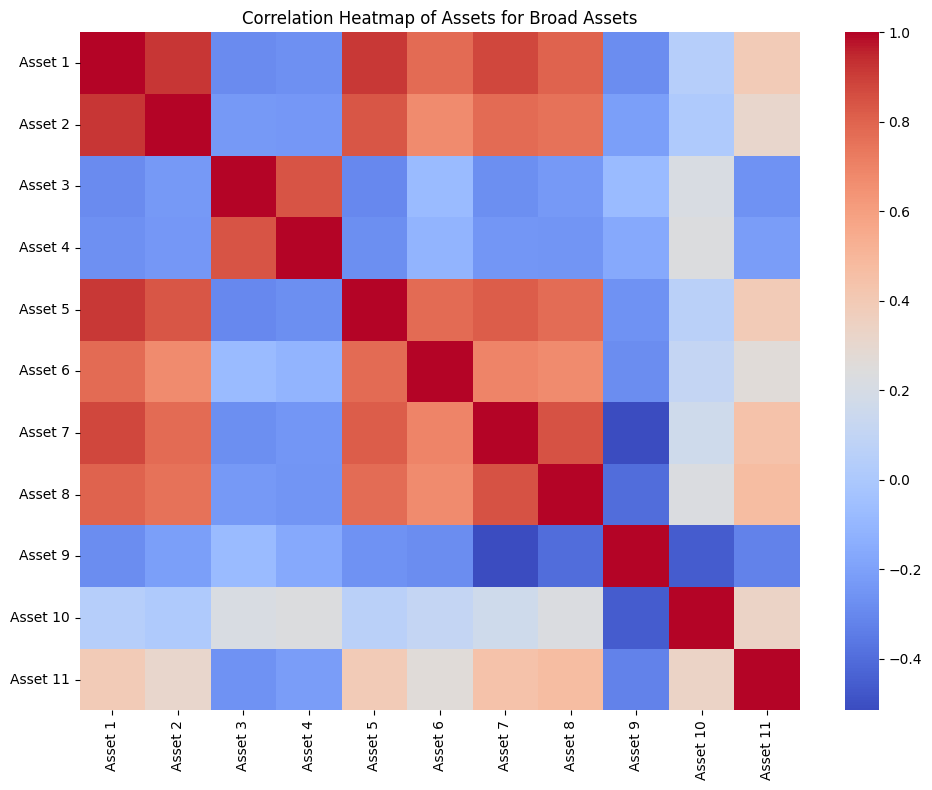

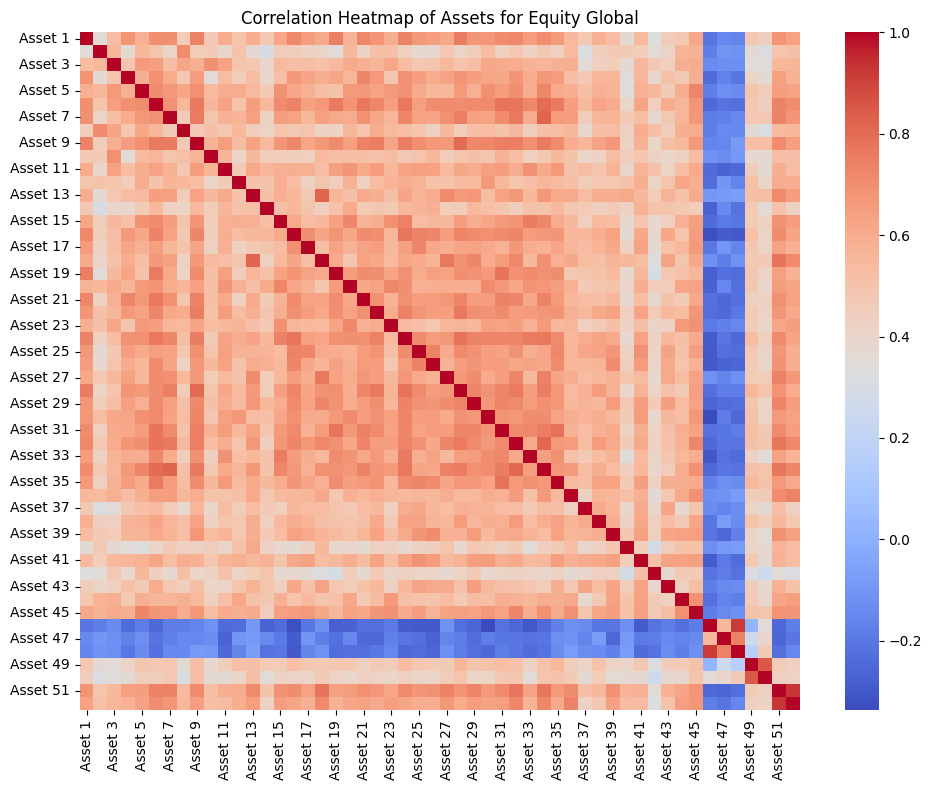

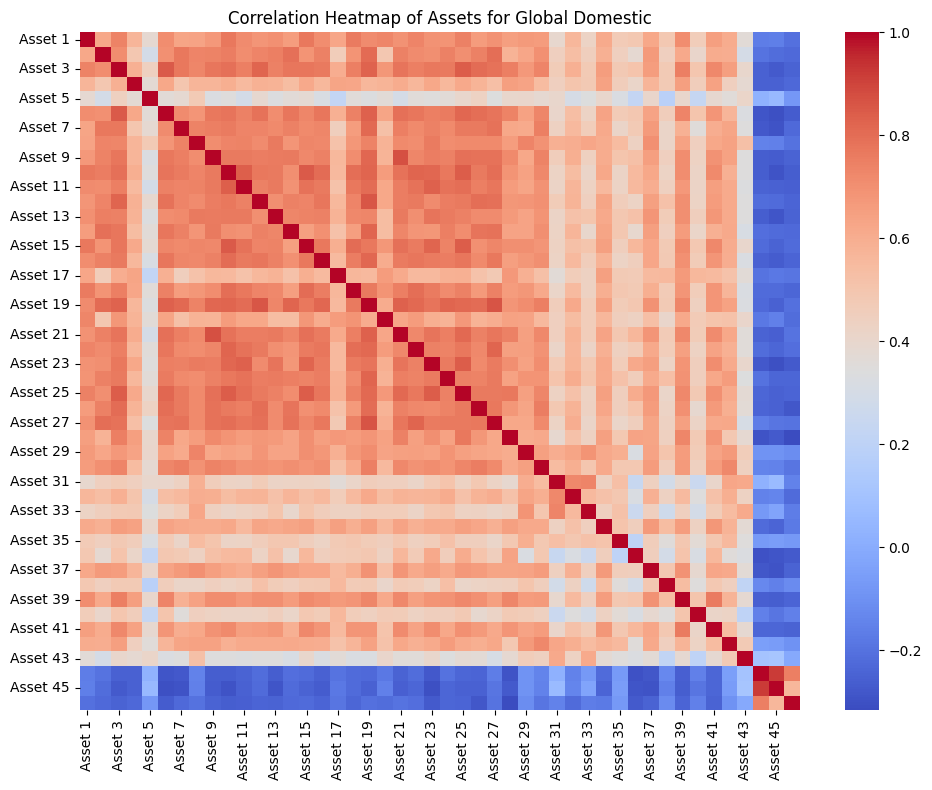

In [14]:
data_dict = {
     'Broad Assets': broad_assets_rets,
     'Equity Global': global_rets,
     'Global Domestic': domestic_rets
}
plot_correlation_heatmaps(data_dict)

### Rolling Sharpe Ratio Analysis

In [15]:
rolling_sharpe = rolling_sharpe_ratio(domestic_rets, window=12)
rolling_sharpe.tail()

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,...,Asset 37,Asset 38,Asset 39,Asset 40,Asset 41,Asset 42,Asset 43,Asset 44,Asset 45,Asset 46
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-01,0.2710,0.1566,0.4959,0.3607,0.1880,-0.1139,0.3273,0.4838,0.1249,0.2740,...,0.2883,-0.2727,0.2725,0.2039,0.1174,0.2240,0.2966,-0.1465,-0.1824,0.3982
2024-06-03,0.3299,0.1925,0.7363,0.3733,0.2098,0.0004,0.4180,0.6371,0.0874,0.2748,...,0.2984,-0.2873,0.3578,0.2685,0.3686,0.2751,0.5282,-0.0629,-0.1153,0.4913
2024-07-01,0.1634,0.0097,0.5939,0.3138,0.1086,-0.1047,0.2082,0.4870,-0.1462,0.0237,...,0.2774,-0.3607,0.1505,0.2547,0.1705,0.2290,0.4031,0.0032,-0.1285,0.8374
2024-08-01,0.2221,-0.0651,0.5183,0.3662,0.1723,-0.0137,0.1717,0.4804,-0.1552,0.0290,...,0.3022,-0.2312,0.1744,0.2127,0.2535,0.2648,0.4543,0.1707,0.0389,0.8474
2024-08-30,0.2563,0.0238,0.4234,0.4794,0.2576,-0.0262,0.1101,0.6075,-0.0043,-0.0473,...,0.3575,-0.1135,0.2181,0.3320,0.1564,0.3740,0.6177,0.2302,0.1102,0.8817


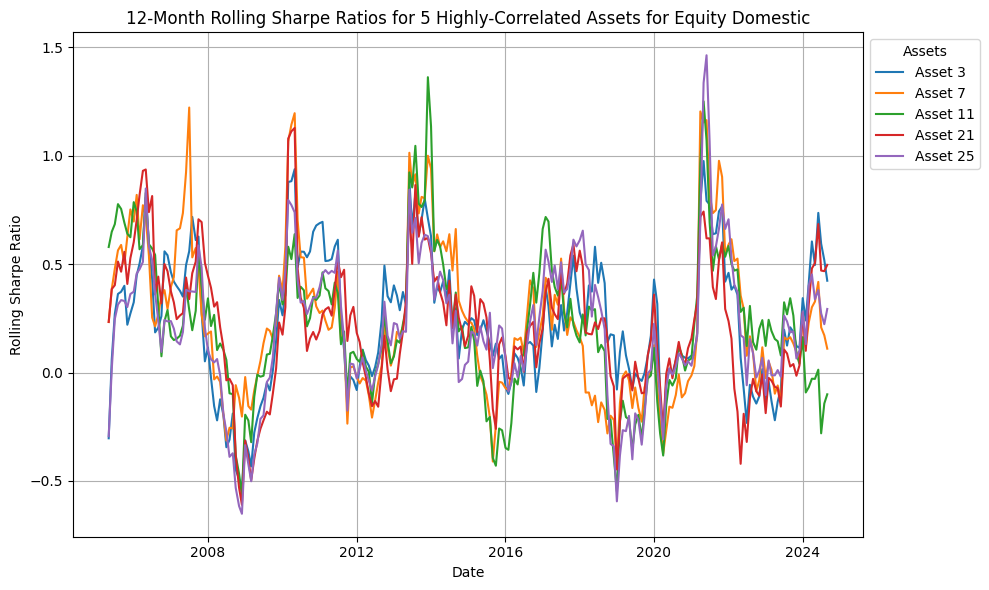

In [16]:
# Select the asset that has relatively high correlations with each other to see
# if the trend of their rolling sharpe align each other
assets_to_plot = ['Asset 3', 'Asset 7', 'Asset 11', 'Asset 21', 'Asset 25']
plt.figure(figsize=(10, 6))
for asset in assets_to_plot:
    plt.plot(rolling_sharpe.index, rolling_sharpe[asset], label=asset)

plt.title('12-Month Rolling Sharpe Ratios for 5 Highly-Correlated Assets for Equity Domestic')
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.legend(title='Assets', loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

The **higher positive correlations** between assets compared to other asset universe in the equity domestic universe and the **similar rolling Sharpe ratios** for each asset suggest that the 46 assets belong to a **highly homogeneous universe**. This homogeneity limits the potential for diversification, which is a critical lever for MVO to outperform simpler methods like equal weighting.

In such a context, MVO cannot significantly differentiate itself because:

- It relies on the variance-covariance matrix to identify diversification opportunities, but with highly correlated assets, diversification potential is minimal.
- The Sharpe ratios being similar across assets mean that risk-adjusted return differences are negligible, offering little room for optimization gains.

Thus, the similar performance of MVO compared to the benchmark and equal-weighted methods is justified by the inherent characteristics of the asset set. The high correlations and similar risk-return profiles of the assets neutralize the advantages that MVO typically offers.